# About Dataset

- A Brain tumor is considered as one of the aggressive diseases, among children and adults. Brain tumors account for 85 to 90 percent of all primary Central Nervous System(CNS) tumors. Every year, around 11,700 people are diagnosed with a brain tumor. The 5-year survival rate for people with a cancerous brain or CNS tumor is approximately 34 percent for men and36 percent for women. Brain Tumors are classified as: Benign Tumor, Malignant Tumor, Pituitary Tumor, etc. Proper treatment, planning, and accurate diagnostics should be implemented to improve the life expectancy of the patients. The best technique to detect brain tumors is Magnetic Resonance Imaging (MRI). A huge amount of image data is generated through the scans. These images are examined by the radiologist. A manual examination can be error-prone due to the level of complexities involved in brain tumors and their properties.
- Application of automated classification techniques using Machine Learning(ML) and Artificial Intelligence(AI)has consistently shown higher accuracy than manual classification. Hence, proposing a system performing detection and classification by using Deep Learning Algorithms using ConvolutionNeural Network (CNN), Artificial Neural Network (ANN), and TransferLearning (TL) would be helpful to doctors all around the world.

![image.png](https://www.mayoclinic.org/ar/-/media/kcms/gbs/patient-consumer/images/2014/10/30/15/17/mcdc7_brain_cancer-8col.jpg)

# import libraries

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import shuffle

import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from IPython.display import display,clear_output

# data visualization

In [23]:
def plot_images(direction):  
    list_direction=os.listdir(direction)

    plt.figure(figsize=(16,10))

    for i in range(1,10):
        plt.subplot(3,3,i)
        img=plt.imread(os.path.join(direction,list_direction[i]))
        plt.imshow(img,cmap='gray')
        plt.axis('off')
    plt.tight_layout()

### visualize glioma tumor

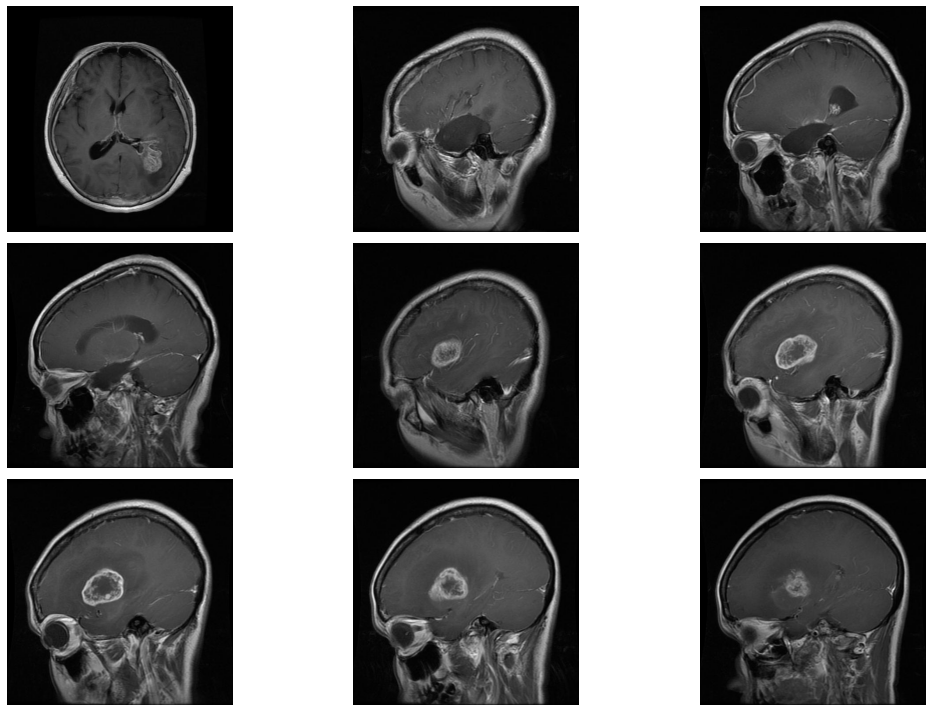

In [25]:
glioma_tumor_dir='Training/glioma_tumor'
plot_images(glioma_tumor_dir)

### visualize meningioma tumor

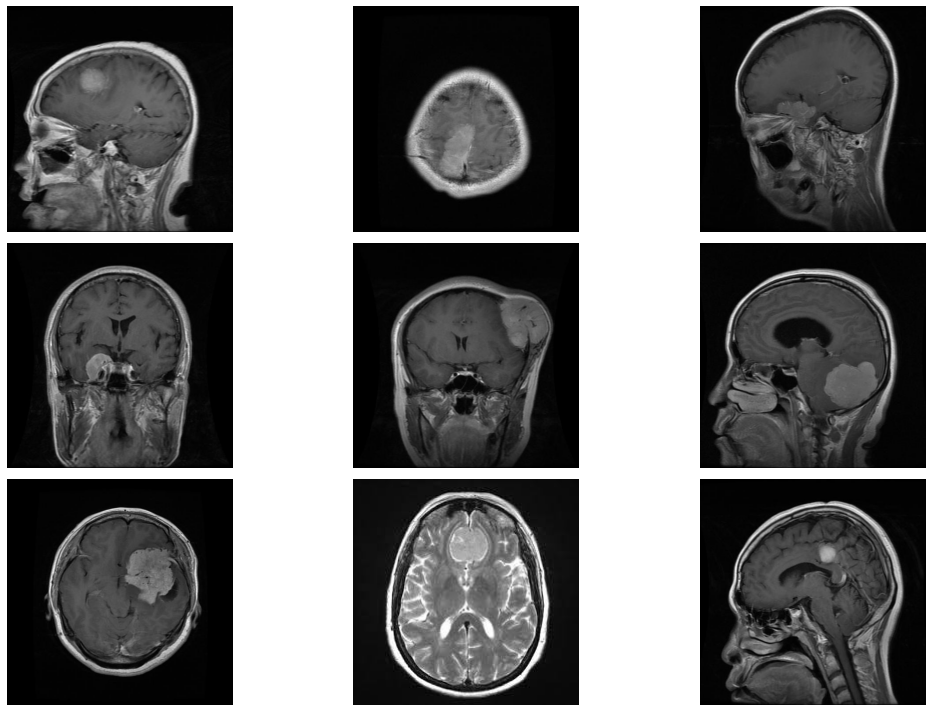

In [4]:
meningioma_tumor_dir='../input/brain-tumor-classification-mri/Training/meningioma_tumor'
plot_images(meningioma_tumor_dir)

### visualize image with no tumor

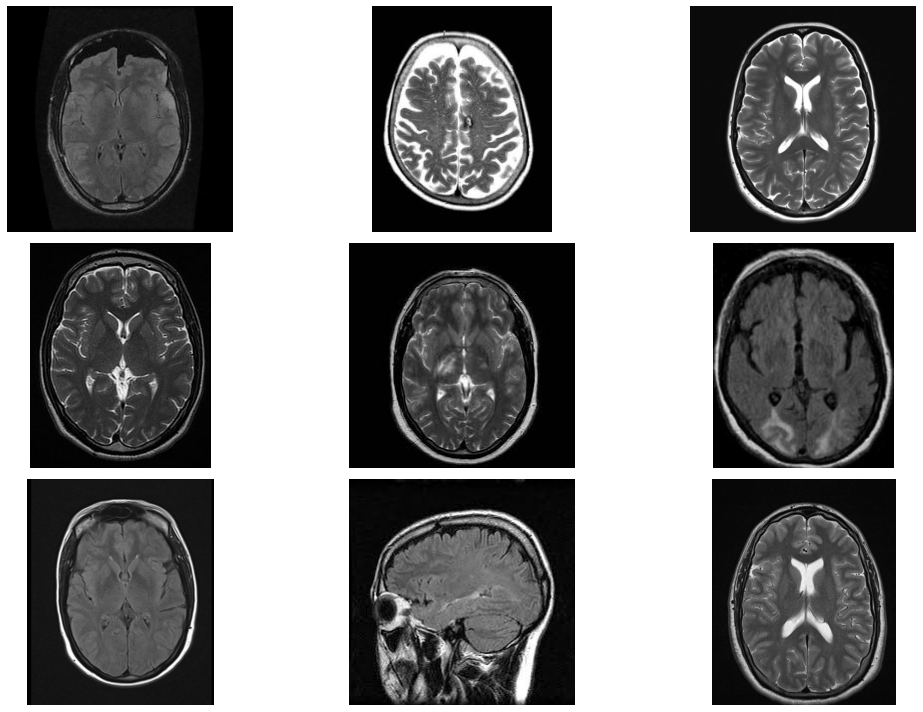

In [5]:
no_tumor_dir='../input/brain-tumor-classification-mri/Training/no_tumor'
plot_images(no_tumor_dir)

### visualize pituitary_tumor


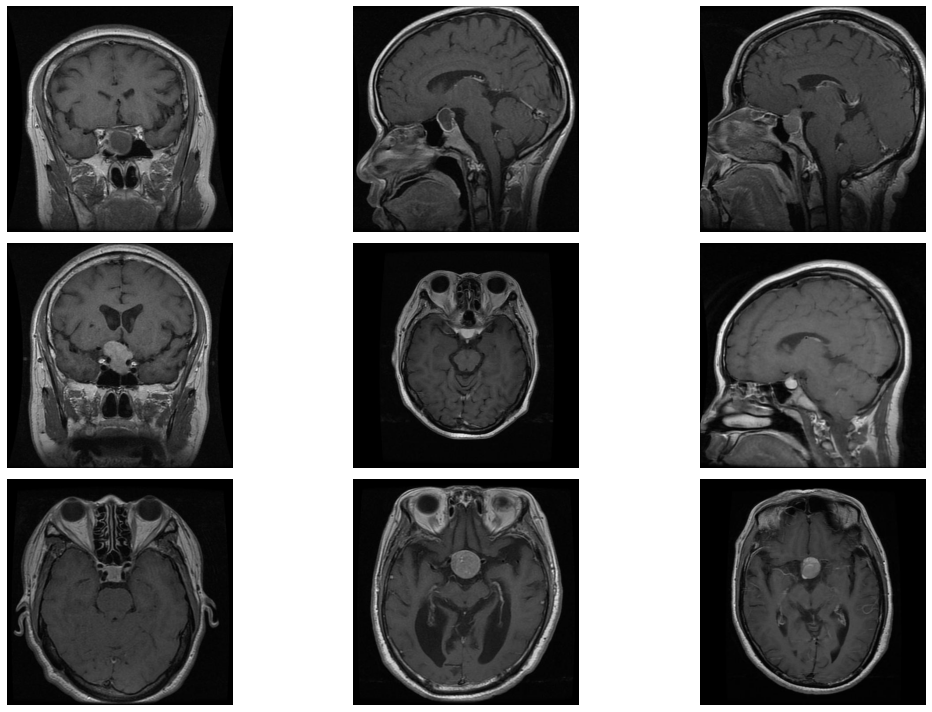

In [6]:
pituitary_tumor_dir='../input/brain-tumor-classification-mri/Training/pituitary_tumor'
plot_images(pituitary_tumor_dir)

# preprocessing

In [26]:
X_train = []
y_train = []
image_size = 150
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
for i in labels:
    folderPath = os.path.join('Training',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('Testing',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

In [27]:
X_train,y_train=shuffle(X_train,y_train,random_state=101)
X_train.shape

(3264, 150, 150, 3)

In [28]:
X_train,X_test,y_train,y_test=train_test_split(X_train,y_train,test_size=.1,random_state=101)

In [29]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))

In [30]:
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

In [31]:

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

## callback setting

In [13]:
early_stopping=keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,min_delta=1e-7,restore_best_weights=True)
reduce_lr=keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=.2,patience=3,min_delta=1e-7)

# Model

In [14]:
def build_model(input_shape):
    
    inputs=keras.layers.Input(input_shape)
    # Block 1
    x=keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='valid')(inputs)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.Activation('relu')(x)
    x=keras.layers.MaxPool2D()(x)
    x=keras.layers.Dropout(.2)(x)
    
    #Block 2
    x=keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='valid')(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.Activation('relu')(x)
    x=keras.layers.MaxPool2D()(x)
    x=keras.layers.Dropout(.2)(x)
    
    #Block 3
    x=keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='valid')(x)
    x=keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='valid')(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.Activation('relu')(x)
    x=keras.layers.MaxPool2D()(x)
    x=keras.layers.Dropout(.4)(x)
    
    # Head
    x=keras.layers.Flatten()(x)
    x=keras.layers.Dense(64,activation='relu')(x)
    x=keras.layers.Dropout(.5)(x)
    # final layer
    output=keras.layers.Dense(4,activation='softmax')(x)
    
    model=keras.Model(inputs,output)
    
    return model

In [15]:
model=build_model((150,150,3))
model.compile(loss='categorical_crossentropy',optimizer=tf.optimizers.Adam(lr=3e-5) ,metrics='accuracy')
model.summary()

2022-04-26 21:18:57.757959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 148, 148, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640  

2022-04-26 21:18:57.845998: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 21:18:57.846729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 21:18:57.847661: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-26 21:18:57.848626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [16]:
history=model.fit(X_train,y_train,epochs=50,validation_split=.1,callbacks=[early_stopping,reduce_lr])

2022-04-26 21:19:00.323534: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-04-26 21:19:01.736994: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


83/83 [==============================] - 8s 20ms/step - loss: 1.5229 - accuracy: 0.3564 - val_loss: 1.2921 - val_accuracy: 0.4048
Epoch 2/50
83/83 [==============================] - 1s 14ms/step - loss: 1.2203 - accuracy: 0.4502 - val_loss: 1.1461 - val_accuracy: 0.5714
Epoch 3/50
83/83 [==============================] - 1s 14ms/step - loss: 1.1314 - accuracy: 0.4934 - val_loss: 1.0790 - val_accuracy: 0.5918
Epoch 4/50
83/83 [==============================] - 1s 14ms/step - loss: 1.0889 - accuracy: 0.5342 - val_loss: 0.9760 - val_accuracy: 0.5986
Epoch 5/50
83/83 [==============================] - 1s 14ms/step - loss: 1.0189 - accuracy: 0.5535 - val_loss: 0.9478 - val_accuracy: 0.6122
Epoch 6/50
83/83 [==============================] - 1s 14ms/step - loss: 1.0053 - accuracy: 0.5645 - val_loss: 0.9123 - val_accuracy: 0.6156
Epoch 7/50
83/83 [==============================] - 1s 14ms/step - loss: 0.9819 - accuracy: 0.5694 - val_loss: 0.8991 - val_accuracy: 0.6156
Epoch 8/50
83/83 [======

# Visusalize model performance

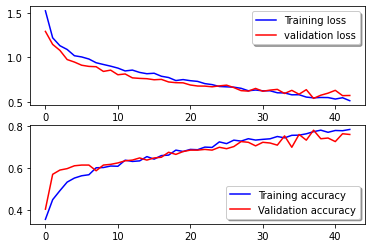

In [17]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# Transfer Learning

Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.

In this notebook, I'll be using the EfficientNetB0 model which will use the weights from the ImageNet dataset.

The include_top parameter is set to False so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case!

In [18]:
 effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(150,150,3))

16719872/16705208 [==============================] - 0s 0us/step


- GlobalAveragePooling2D -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while pooling. This really helps in decreasing the computational load on the machine while training.

- Dropout -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The rate parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

In [19]:
eff_model=effnet.output
eff_model=keras.layers.GlobalAveragePooling2D()(eff_model)
eff_model=keras.layers.Dropout(.5)(eff_model)
eff_model=keras.layers.Dense(4,activation='softmax')(eff_model)
eff_model=keras.Model(inputs=effnet.input,outputs=eff_model)
eff_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 150, 150, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 150, 150, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

In [20]:
eff_model.compile(loss='categorical_crossentropy',optimizer=tf.optimizers.Adam(lr=3e-5) ,metrics='accuracy')


In [21]:
eff_history=eff_model.fit(X_train,y_train,epochs=20,validation_split=.1,callbacks=[early_stopping,reduce_lr])

Epoch 1/20
83/83 [==============================] - 19s 137ms/step - loss: 1.1678 - accuracy: 0.4926 - val_loss: 1.1087 - val_accuracy: 0.5544
Epoch 2/20
83/83 [==============================] - 9s 114ms/step - loss: 0.7492 - accuracy: 0.7389 - val_loss: 0.8545 - val_accuracy: 0.6905
Epoch 3/20
83/83 [==============================] - 10s 117ms/step - loss: 0.5586 - accuracy: 0.8093 - val_loss: 0.8135 - val_accuracy: 0.7007
Epoch 4/20
83/83 [==============================] - 10s 117ms/step - loss: 0.4327 - accuracy: 0.8619 - val_loss: 0.8676 - val_accuracy: 0.6599
Epoch 5/20
83/83 [==============================] - 10s 117ms/step - loss: 0.3695 - accuracy: 0.8751 - val_loss: 0.8665 - val_accuracy: 0.6667
Epoch 6/20
83/83 [==============================] - 10s 118ms/step - loss: 0.3000 - accuracy: 0.9054 - val_loss: 0.8948 - val_accuracy: 0.6633
Epoch 7/20
83/83 [==============================] - 10s 117ms/step - loss: 0.2719 - accuracy: 0.9134 - val_loss: 0.8696 - val_accuracy: 0.6633


# Visusalize model performance

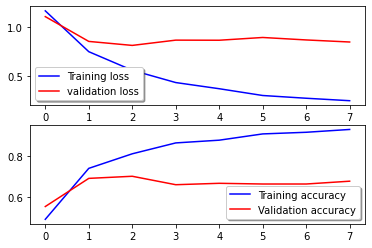

In [22]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(eff_history.history['loss'], color='b', label="Training loss")
ax[0].plot(eff_history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(eff_history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(eff_history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# Evaluate the model

In [23]:
pred = eff_model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 72.17%
